In [2]:
import time
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import dtw

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Preprocessing data

In [3]:
all_x = scipy.io.loadmat('./dataset/timeseries/Trace_data.mat')['data']
all_y = scipy.io.loadmat('./dataset/timeseries/Trace_label.mat')['label'][0]

In [4]:
x, y = [], []

class_1 = 1
class_2 = 4

for i in range(len(all_x)):
  if all_y[i] == class_1 or all_y[i] == class_2:
    x.append(all_x[i][:200])
    y.append(all_y[i])

x = np.array(x)
y = np.array(y)
y = np.where(y == class_2, -1, 1)
y = y.reshape(-1, 1)

print(x)
print(y)

[[ 0.56421375  0.54511617  0.54204671 ...  0.23900864  0.2035571
   0.20117864]
 [ 0.6376156   0.58507817  0.62313348 ...  0.32094571  0.2853001
   0.25950175]
 [-1.4043092  -1.4425306  -1.415186   ...  0.74640323  0.6894699
   0.76927325]
 ...
 [ 0.64550395  0.57923708  0.64327477 ...  0.51632464  0.52290732
   0.55828421]
 [ 0.57311057  0.66785286  0.6204376  ...  0.5212762   0.51004323
   0.5036782 ]
 [-1.4311198  -1.4549623  -1.4688949  ...  0.74562151  0.73998126
   0.76169572]]
[[ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]


In [5]:
# Split test / train
train_cnt = 33

np.random.seed(10)
train_index = np.random.choice(len(x), size=train_cnt, replace=False)
print(train_index)
test_index = [i for i in np.arange(0, len(x)) if i not in train_index]

train_x = x[train_index]
train_y = y[train_index]

test_x = x[test_index]
test_y = y[test_index]

print(np.shape(train_x))
print(np.shape(test_x))

[31 21 27  7 32 24  2 17 18 20 12  6 33  3 26  5 13 14 37 30  1 23 35 11
 40 38 16 19  4 22 34 10 39]
(33, 200)
(10, 200)


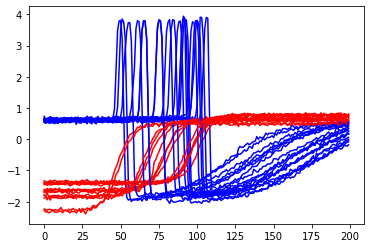

In [6]:
for i in range(len(train_x)):
  plt.plot(train_x[i].ravel(), 'b' if train_y[i] == 1 else 'r')
plt.show()

1
1
-1
-1
-1
1
1
-1
1
-1


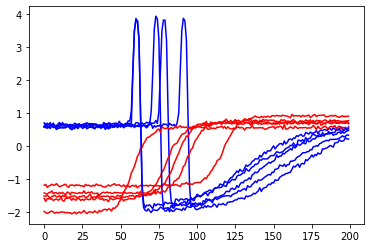

In [7]:
for i in range(len(test_x)):
  print(test_y[i][0])
  plt.plot(test_x[i].ravel(), 'b' if test_y[i] == 1 else 'r')
plt.show()

In [8]:
batch = int(np.shape(train_x)[0] / 2)
batch = int(np.shape(train_x)[0])
iter = 5
lr = 0.01
gamma = 1.8

In [9]:
X = tf.placeholder(shape=[None, None], dtype=tf.float32)
pred_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
test_X = tf.placeholder(shape=[None, None], dtype=tf.float32)

Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)

B = tf.Variable(tf.random_uniform(shape=[1, batch]))

In [10]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [11]:
G = tf.constant(gamma)
dtw_distances = tf.py_function(func=_dtw, inp=[X, X], Tout=[tf.float32 for i in range(batch)])

kernel = tf.exp(-tf.multiply(G, dtw_distances))

In [12]:
first_term = tf.reduce_sum(B)

second_term = tf.reduce_sum(
  tf.multiply(
    kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [13]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X, pred_X], Tout=[tf.float32 for i in range(batch)])
pred_kernel = tf.exp(-tf.multiply(G, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y)), tf.float32))

In [14]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[X, test_X], Tout=[tf.float32 for i in range(batch)])
test_kernel = tf.exp(-tf.multiply(G, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y)), tf.float32))

In [15]:
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [16]:
start = time.time()

loss_vec = []
batch_accuracy = []

rand_index = []
for i in range(iter):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(len(train_x), size=batch, replace=False)
  rand_x = train_x[rand_index]
  rand_y = train_y[rand_index]

  sess.run(train, feed_dict={X: rand_x, Y: rand_y})
  temp_loss = sess.run(loss, feed_dict={X: rand_x, Y: rand_y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={X: rand_x, Y: rand_y, pred_X: rand_x})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
accuracy : 1.0
loss: -5.9869776
time : 148.28817987442017
Step #2
accuracy : 0.93939394
loss: -6.075238
time : 159.12055802345276
Step #3
accuracy : 1.0
loss: -6.162278
time : 144.92627477645874
Step #4
accuracy : 0.969697
loss: -6.2445107
time : 142.15388178825378
Step #5
accuracy : 0.93939394
loss: -6.323784
time : 142.307758808136
Total time : 736.7978961467743


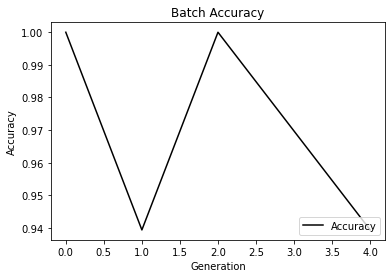

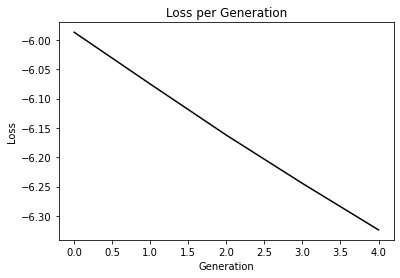

In [17]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [18]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          X: train_x[rand_index],
                          Y: train_y[rand_index],
                          test_X: test_x
                      })

In [19]:
test_acc = sess.run(test_accuracy,
                      feed_dict={
                          X: train_x[rand_index],
                          Y: train_y[rand_index],
                          test_X: test_x,
                          test_Y: test_y
                      })

In [20]:
print(test_acc)

1.0


In [21]:
test_preds = np.squeeze(test_preds)
_test_y = np.squeeze(test_y)

colors = []
cnt = 0
for i in range(len(test_preds)):
  if test_preds[i] == _test_y[i]:
    cnt += 1
    colors.append('b')

  else:
    colors.append('r')

print(cnt)
print(cnt / len(test_preds))


10
1.0


## Influence function

### Gradient for target data

In [24]:
inf_x = tf.placeholder(shape=[None, None], dtype=tf.float32)
inf_dtw_distances = tf.py_function(func=_dtw, inp=[x, inf_x], Tout=[tf.float32 for i in range(batch)])
inf_kernel = tf.exp(-tf.multiply(G, inf_dtw_distances))

In [25]:
inf_kernel_value = sess.run(inf_kernel,
                            feed_dict={X: train_x[rand_index],
                                       inf_x: [test_x[0]]})

In [33]:
inf_first_term = tf.reduce_sum(B)

inf_second_term = tf.reduce_sum(
  tf.multiply(
    inf_kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))
inf_gradient = tf.gradients(inf_loss, [B])
inf_hessian = tf.hessians(inf_loss, [B])

In [51]:
target_gradient = sess.run(inf_gradient,
                           feed_dict={
                             X: train_x[rand_index],
                             Y: train_y[rand_index],
                             inf_x: [test_x[0]]})

target_gradient = np.squeeze(target_gradient)

In [62]:
print(np.shape(target_gradient))
print(np.shape(rand_index))
print(rand_index)

(33,)
(33,)
[32  5 20 15 31 19 29 11 27  2 18 10 16  8  6 14 26 12 22  3  0 25 28 24
  7 23  4  1  9 13 30 21 17]


In [64]:
R = 10
s_test = 0
for r in range(R):
  v = target_gradient
  s_test_j = v
  for i in range(len(rand_index)):
    print('# R: ', (r+1))
    print('# train: ', (i+1))
    train_x_hessian = sess.run(inf_hessian,
                               feed_dict={
                                X: train_x[rand_index],
                                Y: train_y[rand_index],
                                inf_x: [train_x[i]]
                               })
    train_x_hessian = np.squeeze(train_x_hessian)
    train_x_hessian = np.diag(train_x_hessian)
    train_x_hessian = np.identity(np.shape(train_x_hessian)[0]) - train_x_hessian

    s_test_j = v + np.matmul(train_x_hessian, s_test_j)
  s_test += s_test_j

s_test = s_test / R

infs = []
for i in range(len(rand_index)):
  train_x_gradient = sess.run(inf_gradient,
                              feed_dict={
                                X: train_x[rand_index],
                                Y: train_y[rand_index],
                                inf_x: [train_x[i]]
                              })
  train_x_gradient = np.squeeze(train_x_gradient)
  inf_value = -np.matmul(s_test, train_x_gradient)
  infs.append((rand_index[i], inf_value))

print(infs)

# R:  1
# train:  1
# R:  1
# train:  2
# R:  1
# train:  3
# R:  1
# train:  4
# R:  1
# train:  5
# R:  1
# train:  6
# R:  1
# train:  7
# R:  1
# train:  8
# R:  1
# train:  9
# R:  1
# train:  10
# R:  1
# train:  11
# R:  1
# train:  12
# R:  1
# train:  13
# R:  1
# train:  14
# R:  1
# train:  15
# R:  1
# train:  16
# R:  1
# train:  17
# R:  1
# train:  18
# R:  1
# train:  19
# R:  1
# train:  20
# R:  1
# train:  21
# R:  1
# train:  22
# R:  1
# train:  23
# R:  1
# train:  24
# R:  1
# train:  25
# R:  1
# train:  26
# R:  1
# train:  27
# R:  1
# train:  28
# R:  1
# train:  29
# R:  1
# train:  30
# R:  1
# train:  31
# R:  1
# train:  32
# R:  1
# train:  33
# R:  2
# train:  1
# R:  2
# train:  2
# R:  2
# train:  3
# R:  2
# train:  4
# R:  2
# train:  5
# R:  2
# train:  6
# R:  2
# train:  7
# R:  2
# train:  8
# R:  2
# train:  9
# R:  2
# train:  10
# R:  2
# train:  11
# R:  2
# train:  12
# R:  2
# train:  13
# R:  2
# train:  14
# R:  2
# train:  15
# R:  2
# 

8
11
32
18
10
12
15
31
26
9


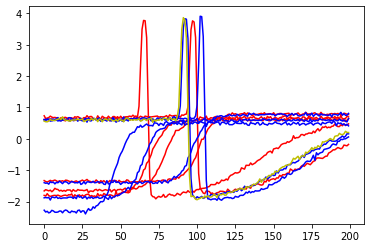

In [82]:
infs = sorted(infs, key=lambda x: x[1])

harmful = infs[:5]
helpful = infs[28:]

for i in range(len(harmful)):
  idx = int(harmful[i][0])
  print(idx)
  plt.plot(train_x[idx], 'r')

for i in range(len(helpful)):
  idx = int(helpful[i][0])
  print(idx)
  plt.plot(train_x[idx], 'b')

plt.plot(test_x[0], 'y')
plt.show()

In [ ]:
################
inf_target_x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='train_X')
inf_dtw_distances = tf.py_function(func=_dtw, inp=[x, inf_target_x], Tout=[tf.float32 for i in range(BATCH_SIZE)])
inf_kernel = tf.exp(-tf.multiply(gamma, inf_dtw_distances))

inf_first_term = tf.reduce_sum(b)

inf_b_vec_cross = tf.matmul(tf.transpose(b), b)
inf_train_Y_cross = tf.matmul(y, tf.transpose(y))
inf_second_term = tf.reduce_sum(
    tf.multiply(inf_kernel, tf.multiply(inf_b_vec_cross, inf_train_Y_cross))
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))

### test data gradient

In [ ]:
z_grad_op = tf.gradients(inf_loss, [b])
z_hess_op = tf.hessians(loss, [b])

In [ ]:
test_idx = 4
plt.plot(test_X[test_idx])
plt.show()

In [ ]:
z_test_grad = sess.run(z_grad_op, feed_dict={x: train_X[rand_index], y: train_Y[rand_index], inf_target_x: [test_X[test_idx]]})
z_test_grad = np.squeeze(z_test_grad)

In [ ]:
z_hess = sess.run(z_hess_op, feed_dict={x: train_X[rand_index], y: train_Y[rand_index]})
z_hess = np.squeeze(z_hess)
z_inv_hess = np.linalg.inv(z_hess)

### Get influence value on test data

In [ ]:
infs = []
for i in range(np.shape(train_X[rand_index])[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X[rand_index], y: train_Y[rand_index], inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)

  z_hess_grad = np.dot(z_inv_hess, z_train_grad)
  inf_value = -np.dot(z_test_grad, z_hess_grad)
  infs.append((i, inf_value))

infs = sorted(infs, key=lambda x: x[1])


In [ ]:
train_X[rand_index][0]

In [ ]:
print(np.shape(infs))
print(infs)

In [ ]:
for i in range(len(infs)):
  idx = int(infs[i][0])
  color = 'k'
  if i < 3:
    color = 'r'
  elif i > 11:
    color = 'b'

  plt.plot(train_X[rand_index][idx], color)

plt.plot(test_X[test_idx], 'y')
plt.show()

### Get influence value on train data

In [ ]:
print(z_test_grad)

In [ ]:
loo_infs = []
for i in range(np.shape(train_X)[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)
  z_hess_grad = np.dot(z_inv_hess, z_train_grad)
  inf_value = -np.dot(z_train_grad, z_hess_grad)
  loo_infs.append((i, inf_value))

In [ ]:
loo_infs = np.absolute(loo_infs)
print(loo_infs)

In [ ]:
loo_infs = sorted(loo_infs, key=lambda x: x[1])
print(loo_infs)

for i in range(len(loo_infs)):
  idx = int(loo_infs[i][0])
  color = 'b'
  if i < 14:
    color = 'k'

  plt.plot(train_X[idx], color)

plt.show()

In [ ]:
z_hess_op2 = tf.hessians(inf_loss, [b])

z_test_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [test_X[test_idx]]})
z_test_grad = np.squeeze(z_test_grad)

infs = []
for i in range(np.shape(train_X)[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)

  z_train_hess = sess.run(z_hess_op2, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_hess = np.squeeze(z_train_hess)
  z_train_hess = np.diag(z_train_hess)
  z_train_hess = np.identity(20) - z_train_hess
  z_train_inv_hess = np.linalg.inv(z_train_hess)

  z_hess_grad = np.dot(z_train_inv_hess, z_train_grad)
  inf_value = -np.dot(z_test_grad, z_hess_grad)
  infs.append((i, inf_value))

infs = sorted(infs, key=lambda x: x[1])

In [ ]:
for i in range(len(infs)):
  idx = int(infs[i][0])
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 14:
    color = 'b'

  plt.plot(train_X[idx], color)

plt.plot(test_X[test_idx], 'y')
plt.show()

In [ ]:
z_hess_op2 = tf.hessians(inf_loss, [b])

z_test_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [test_X[test_idx]]})
z_test_grad = np.squeeze(z_test_grad)

infs = []

s_test = 0
for j in range(20):
  s_test_j = z_test_grad
  print(j)

  for i in range(np.shape(train_X)[0]):

    z_train_hess = sess.run(z_hess_op2, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
    z_train_hess = np.squeeze(z_train_hess)
    z_train_hess = np.diag(z_train_hess)
    z_train_hess = np.identity(20) - z_train_hess
    s_test_j = z_test_grad + np.matmul(z_train_hess, s_test_j)

  s_test += s_test_j

s_test = s_test / 20

for i in range(np.shape(train_X)[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)

  inf_value = -np.matmul(s_test, z_train_grad)
  infs.append((i, inf_value))

infs = sorted(infs, key=lambda x: x[1])

In [ ]:
print(infs)

In [ ]:
for i in range(len(infs)):
  idx = int(infs[i][0])
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 14:
    color = 'b'

  plt.plot(train_X[idx], color)

plt.plot(test_X[test_idx], 'y')
plt.show()